ENV: celiac_env_3

# Sample annotations

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
# import spatialdata as sd
# import spatialdata_io
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(0)
import geopandas as gpd
import matplotlib.pyplot as plt
# import spatialdata_plot
import os
# import dask.dataframe as dd
from adjustText import adjust_text
from datetime import datetime
import dill
import scipy
import sys
import plotly.express as px
import importlib
import squidpy as sq
from statsmodels.stats.multitest import multipletests
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import to_rgba
import gseapy as gp
import session_info2


import plot_gsea

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({
    "font.size": 14,    
    "axes.titlesize": 16,    
    "axes.labelsize": 14,  
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,  
    "legend.fontsize": 14
})

/home/talbarka/miniconda3/envs/celiac_env3/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/talbarka/miniconda3/envs/celiac_env3/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


In [2]:
TEXT_OUTPUT_MODE = False
fast_load = True
if fast_load:
    fast_load_prefix = "/mnt/d/celiac_files/"
else:   
    fast_load_prefix = ""

In [3]:
# add clinical diagnosis 
metadata_path = "../20251104_metadata_updated.xlsx"
metadata_df = pd.read_excel(metadata_path, index_col=0)

# DROPPED: 60,73,80B2, 109B2 

b2_visium_hd_samples = ["ST_033","ST_046","ST_038","ST_052","ST_004","ST_072","ST_054","ST_102"] # ,"ST_060","ST_073"
b1_visium_hd_samples = ["ST_076","ST_105","ST_080","ST_109"]
double_visium_hd_samples = [] #["ST_109"]# "ST_080",
flex_samples = ["ST_054","ST_116","ST_123","ST_072","ST_046","ST_076","ST_038","ST_033","ST_052","ST_105", "ST_004"] #"ST_073",,"ST_080","ST_060","ST_109","ST_120",

all_samples = list(set(b2_visium_hd_samples + b1_visium_hd_samples  + flex_samples))#+ double_visium_hd_samples

age_groups_limits = [8,12,16]

samples_summary_df = pd.DataFrame({
    "Diagnosis": [metadata_df.loc[sample, "Group"] for sample in all_samples],
    "Sex": [
        "Male" if metadata_df.loc[sample, "Sex"] == "M" else
        "Female" if metadata_df.loc[sample, "Sex"] == "F" else
        metadata_df.loc[sample, "Sex"]
        for sample in all_samples
    ],
    "Age": [np.round(metadata_df.loc[sample, "age"]*2)/2 for sample in all_samples],
    # "Age_group": [
    #     "4-8" if metadata_df.loc[sample, "age"] <= age_groups_limits[0] else
    #     ("8-12" if metadata_df.loc[sample, "age"] <= age_groups_limits[1] else
    #     ("12-16" if metadata_df.loc[sample, "age"] <= age_groups_limits[2] else np.nan))
    #     for sample in all_samples
    # ],
    # "VisiumHD_group": [
    #     "B2" if sample in b2_visium_hd_samples else
    #     ("B1" if sample in b1_visium_hd_samples else
    #     ("B1+B2" if sample in double_visium_hd_samples else np.nan))
    #     for sample in all_samples
    # ],
    "TTG_value": [metadata_df.loc[sample, "TTG_value"] for sample in all_samples],
    "VisiumHD":[ # this is previously "visiumhd_binary"
        True if sample in (b2_visium_hd_samples + b1_visium_hd_samples + double_visium_hd_samples) else False
        for sample in all_samples
    ],
    "Flex": [True if sample in flex_samples else False for sample in all_samples],
}, index=all_samples)

# make sure to have capital initial at specific fields
capital_initial_fields = ["Diagnosis","Sex"]
for field in capital_initial_fields:
    samples_summary_df[field] = samples_summary_df[field].str.capitalize()

show_df = samples_summary_df.loc[:,["Diagnosis","Sex","Age","TTG_value","VisiumHD","Flex"]].copy()
show_df.sort_values(by=["Diagnosis"], inplace=True)

# lower case all columns
show_df.columns = [col.lower() for col in show_df.columns]

show_df

,diagnosis,sex,age,ttg_value,visiumhd,flex
ST_116,Celiac,Male,10.0,250.0,False,True
ST_054,Celiac,Male,5.5,250.0,True,True
ST_102,Celiac,Male,10.0,250.0,True,False
ST_080,Celiac,Female,8.5,45.0,True,False
ST_076,Celiac,Female,5.5,250.0,True,True
ST_105,Celiac,Female,4.5,250.0,True,True
ST_004,Celiac,Male,11.5,250.0,True,True
ST_072,Celiac,Male,8.5,154.0,True,True
ST_109,Celiac,Female,5.0,79.0,True,False
ST_052,Control,Female,15.0,0.5,True,True


In [4]:
def annotation_strip(df, feature_order=None, sample_order=None, palettes=None, 
                     cell_size=1.0, na_color="white", show_legend=True, dashed_line_loc = None, fig_dpi = 300,text_dict = {}):
    if feature_order is None:
        feature_order = df.columns.tolist()
    if sample_order is None:
        sample_order = df.index.tolist()
    
    n_features = len(feature_order)
    n_samples = len(sample_order)
    
    fig, ax = plt.subplots(figsize=(n_samples*cell_size/4, n_features*cell_size/2), dpi=fig_dpi)

    for i, feat in enumerate(feature_order):
        col = df.loc[sample_order, feat]
        unique_vals = pd.Series(col.dropna().unique())
        

        # Palette (only if not raw colors)
        if palettes and feat in palettes:
            pal = palettes[feat]
        else:
            cmap = plt.get_cmap("tab20", len(unique_vals))
            pal = {val: cmap(j) for j, val in enumerate(unique_vals)}
        
        for j, sample in enumerate(sample_order):
            val = col[sample]

            # Decide color
            color = na_color
            if pd.notna(val):
                try:
                    # Try to interpret val as a color directly
                    color = to_rgba(val)
                except ValueError:
                    # Otherwise, map with palette
                    color = pal.get(val, na_color)
            
            rect = Rectangle((j, n_features - i - 1), 1, 1, 
                             facecolor=color, edgecolor="white", linewidth=0.5)
            ax.add_patch(rect)

            if val in text_dict:
                display_val = text_dict[val]
                ax.text(j + 0.5, n_features - i - 0.5, str(display_val), ha="center", va="center", fontsize=6, color="black")
    
    # add vertical between subplot columns
    if dashed_line_loc is not None:
        ax.axvline(x=dashed_line_loc, color="black", linestyle="--", linewidth=1.5)

    ax.set_xlim(0, n_samples)
    ax.set_ylim(0, n_features)
    ax.set_xticks([])
    ax.set_yticks([n_features - i - 0.5 for i in range(n_features)])
    ax.set_yticklabels(feature_order)
    ax.invert_yaxis()
    ax.set_aspect("equal")
    
    ax.set_xticks(np.arange(n_samples) + 0.5)  # centers of the cells
    ax.set_xticklabels([str(s) for s in sample_order],
                       rotation=90, ha="center", va="top", fontsize=8)  # **NEW**
    ax.tick_params(axis="x", length=0)  # **NEW**
    fig.subplots_adjust(bottom=0.25)    # **NEW** give space for rotated labels

    if show_legend:
        handles = []
        for f_idx, feat in enumerate(reversed(feature_order)):
            col = df.loc[sample_order, feat]
            vals = pd.Series(col.dropna().unique())
            if palettes and feat in palettes:
                pal = palettes[feat]
            else:
                cmap = plt.get_cmap("tab20", len(vals))
                pal = {val: cmap(j) for j, val in enumerate(vals)}
            for v, c in pal.items():
                try:
                    c = to_rgba(c)  # normalize
                except ValueError:
                    continue
                handles.append(Patch(color=c, label=f"{feat}: {v}"))

            if f_idx != len(feature_order) - 1:
                handles.append(Patch(facecolor=(0, 0, 0, 0), edgecolor='none', linewidth=0, label=" "))

        ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, frameon=False)
    
    return fig, ax

def prettify_field(field):
    return field.replace('_', ' ')

In [5]:
# select_prctl = 75
crypt_field_name = 'crypt'
villus_field_name = 'villus'
lymph_sum_field_name = 'mean_lymph_sum'
sample_field_name = 'sample_name'
sample_field_name_all = 'sample_name_all'
ratio_field_name = 'villus_crypt_ratio'
disease_class = "disease_class"
disease_class_description = disease_class + "_description"
diagnosis_class_field_name = "diagnosis"
ratio_field_name_max = 'villus_crypt_ratio_max'
added_disease_class = ratio_field_name_max
diagnosis_field_name ="diagnosis"

In [6]:
show_df.loc["ST_038","ttg_value"] = "N/A"

/tmp/ipykernel_3475900/3197038272.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  show_df.loc["ST_038","ttg_value"] = "N/A"


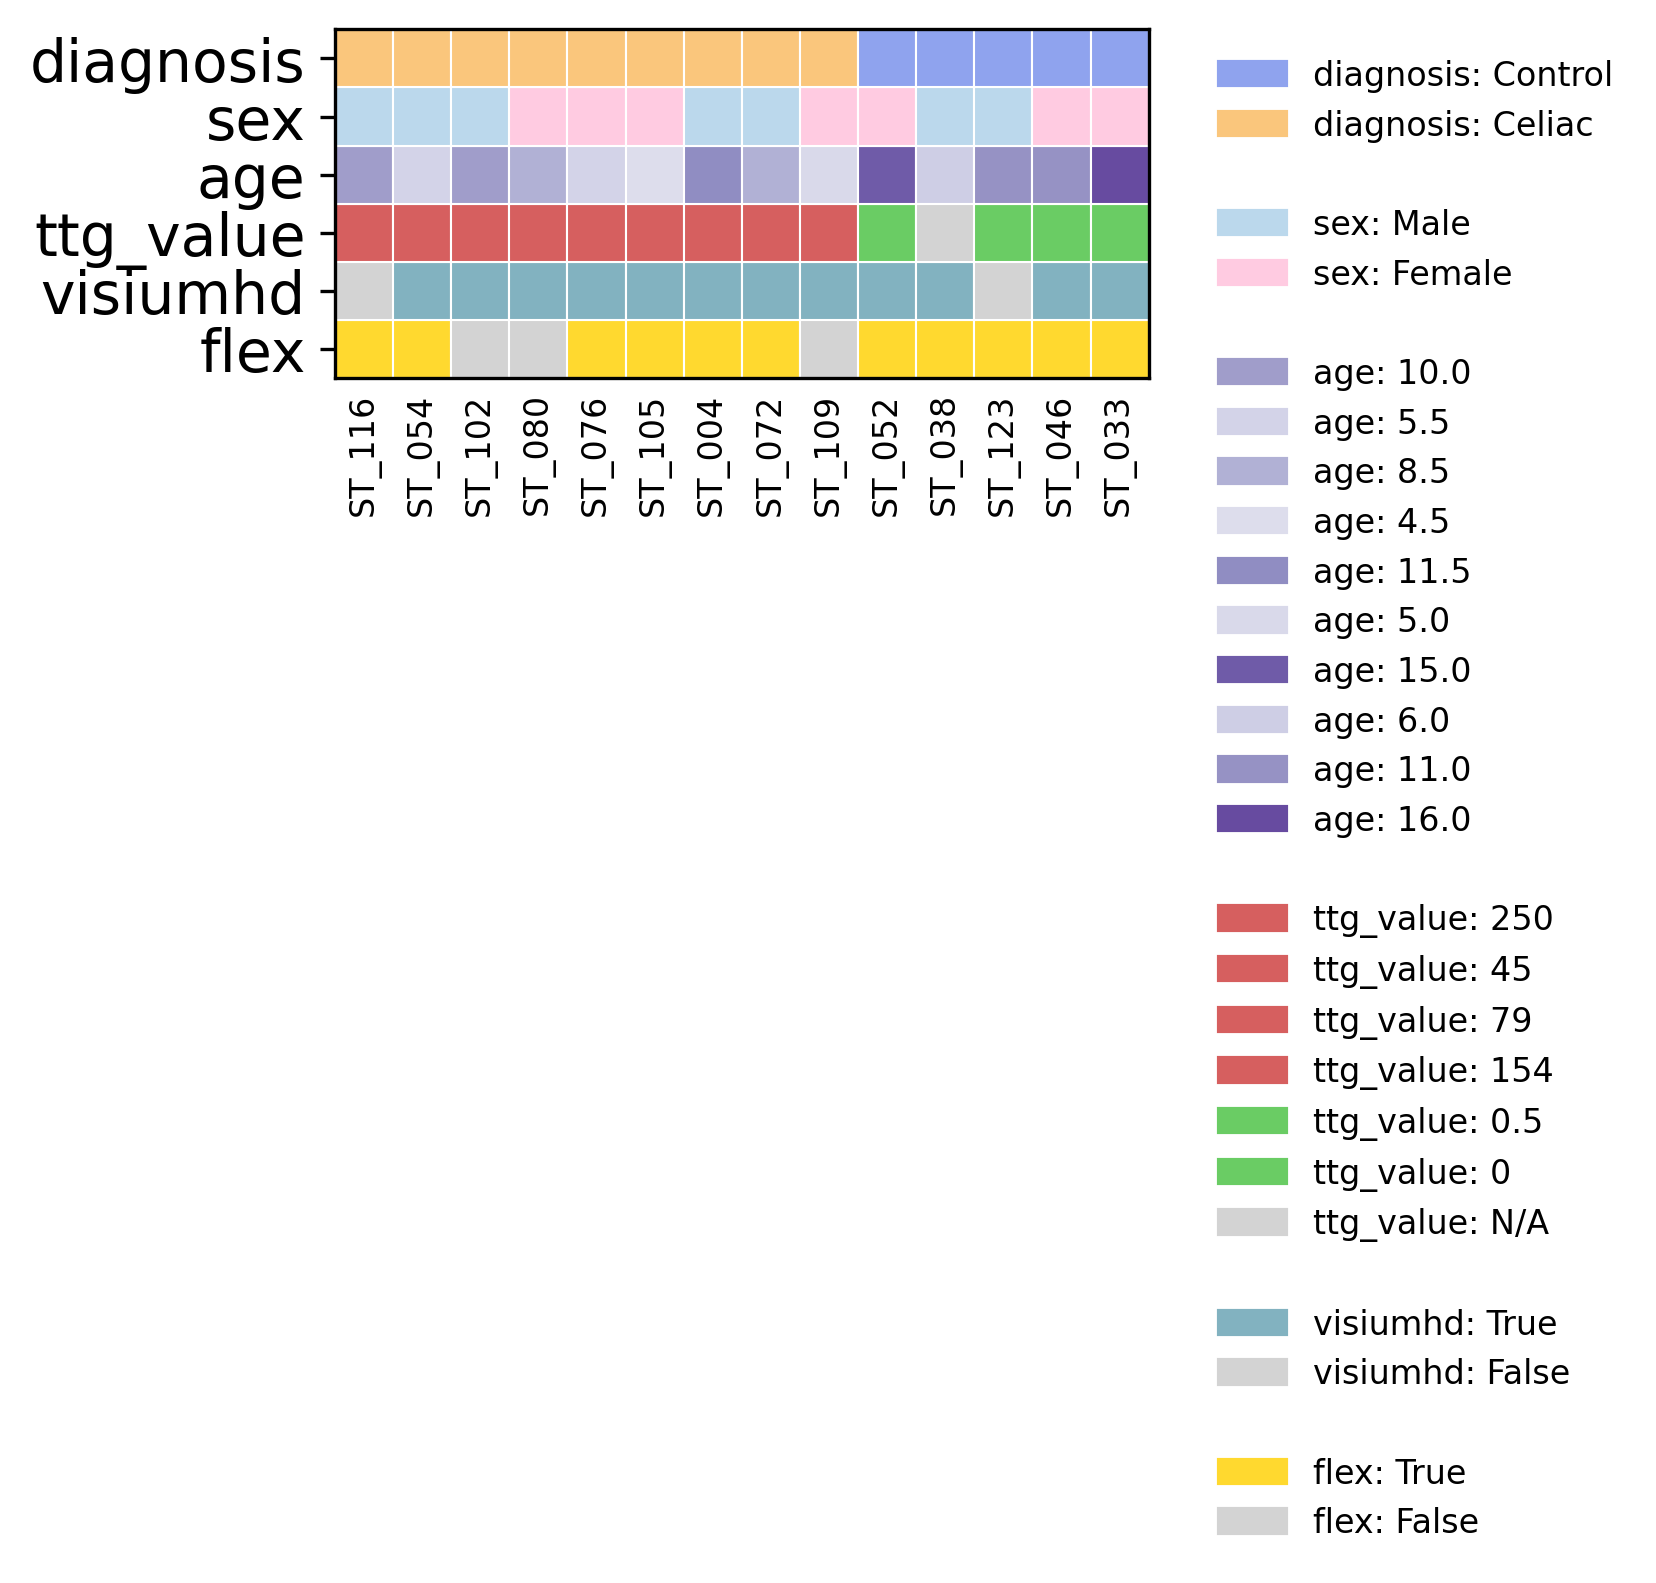

In [7]:
positive_ttg_color = "#d65f5f"
negative_ttg_color = "#6acc64"
nan_ttg_color = "#d3d3d3"
show_palettes = {
    "diagnosis": {"Control": "#8fa3ee", "Celiac": "#fac67c"},  # Control: blue, CeD: orange
    "sex": {"Male": "#bbd8ec", "Female": "#ffcbe1"},
    "age": {"4-8": "#efcbe3", "8-12": "#c79ec7", "12-16": "#9a69b3"},  # light to darker blue
    "ttg_value":{250:positive_ttg_color,45:positive_ttg_color, 79:positive_ttg_color, 154:positive_ttg_color, 0.5:negative_ttg_color, 0:negative_ttg_color, "N/A":nan_ttg_color},
    "visiumhd_group": {"B1": "#d28a8d", "B2": "#82b2c0", "B1+B2": "#f6c7b2", np.nan: "#d3d3d3"},  # Red, Green, Blue
    "visiumhd": {True: "#82b2c0", False: "#d3d3d3"},
    "flex": {True: "#ffd92f", False: "#d3d3d3"},
    "disease_class": {
        "villus crypt ratio ≥ 1": "#87addc",
        "1 > villus crypt ratio ≥ 0.5": "#fdcab9",
        "0.5 > villus crypt ratio ≥ 0.25": "#8bc5a5",
        "villus crypt ratio < 0.25": "#ff7f74",
    },
    added_disease_class: {
        "villus crypt ratio > 1": "#f8d8d5",
        "0.5 < villus crypt ratio ≤ 1": "#FAB9A3",
        "0.25 < villus crypt ratio ≤ 0.5": "#FD9183",
        "villus crypt ratio ≤ 0.25": "#F05A47",
        False: "#d3d3d3"
    }
}

# add age palette
# Normalize the ages to a range between 0 and 1
age_min, age_max = show_df['age'].min()-5, show_df['age'].max()+5
normalized_ages = (show_df['age'] - age_min) / (age_max - age_min)

# Generate a palette of purples based on the normalized ages
age_palette = sns.color_palette("Purples", as_cmap=True,)

# Map normalized ages to the palette
show_palettes['age'] = {age: age_palette(norm) for age, norm in zip(show_df['age'], normalized_ages)}

disease_class_palette = [show_palettes[added_disease_class][key] for key in show_palettes[added_disease_class]]

fig, ax = annotation_strip(show_df, palettes=show_palettes, feature_order = ["flex","visiumhd","ttg_value","age","sex","diagnosis"], cell_size=1.0)
plt.show()

In [8]:
with open(fast_load_prefix+'joint_ad.dill', 'rb') as f:
    all_ad = dill.load(f)
all_ad

AnnData object with n_obs × n_vars = 718521 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'cell_x_um', 'cell_y_um', 'geometry', 'sample_name', 'macrozone', 'MM_LP_crypt', 'brunner', 'villus', 'immune', 'lowest_lumen', 'crypt_base', 'pixel_class', 'bc', 'slide', 'sum_of_umis', 'block_id', 'pt', 'age', 'sex', 'group', 'ttg', 'inflammation_bulb', 'inflammation_2nd_part', 'visium_batch', 'dv200', 'uscd', 'block_name', 'notes', 'median_sum_of_umis', 'crypt_villi_part'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    layers: 'counts', 'mat_norm', 'log_norm'

In [9]:
# samples_to_drop = ["ST_060","ST_073","ST_080B1","ST_080B2", "ST_109B1","ST_109B2"]
samples_to_drop = ["ST_060","ST_073","ST_080B2","ST_109B2"]
print(all_ad.shape)
all_ad = all_ad[~all_ad.obs.sample_name.isin(samples_to_drop)]
print(all_ad.shape)

(718521, 18085)
(518635, 18085)


In [10]:
# check if there is existing subfolder for pseudobulk data
pb_subfolder_path = os.getcwd()+"/pseudobulk_data/"
if not os.path.exists(pb_subfolder_path):
    os.makedirs(pb_subfolder_path)

## Calcualte parameters for samples classification

In [11]:
# load pseudobulk data from scFlex background subtracted data lvl1 (generated using 03_scFlex_bg_substraction_UMI500.ipynb)
pb_lvl1 = pd.read_csv(pb_subfolder_path+"pseudobulk_cell_type_lvl1_bg_subtracted_UMI500.csv", index_col=0)

# select immune markers from pseudobulk data
min_fc = 10
min_exp = 1e-4
PN=1e-6

immune_markers_mask = pb_lvl1.index[
    (((pb_lvl1['Immune']+PN) / (pb_lvl1.drop('Immune', axis=1).max(axis=1)+PN)) >= min_fc)
    &
    (pb_lvl1['Immune'] >= min_exp)
]
immune_markers = pb_lvl1.loc[immune_markers_mask].index.tolist()
print(f"Selected {len(immune_markers)} immune markers.")

Selected 33 immune markers.


In [12]:
# for each sample calculate celiac severity score composed of the following:
# 1. 75% percentile of the distance from crypt-villus axis - of crypt epithelium
# 2. 75% percentile of the distance from crypt-villus axis - of villus epithelium
# 3. sum of lymphocytes markers

# draw boxplot of the distance from crypt-villus axis for each sample
epithelium_mask = all_ad.obs.pixel_class == "epithelium"
non_epithelium_mask = all_ad.obs.pixel_class == "non_epithelium"

selected_genes = immune_markers
selected_genes_sum = all_ad[:,selected_genes].layers['mat_norm'].sum(axis=1)
all_ad.obs['lymphocytes_sum'] = selected_genes_sum


compartment_to_scan = ["epithelium","non_epithelium","all"]
scan_mask = {"epithelium": epithelium_mask, "non_epithelium": non_epithelium_mask, "all": epithelium_mask | non_epithelium_mask}

compartment_dict = dict()
for compartment in compartment_to_scan:
    sample_crypt_villus_prctls = pd.DataFrame(index=all_ad.obs.sample_name.dropna().unique(), 
                                              columns=[sample_field_name, lymph_sum_field_name])

    for sample in all_ad.obs.sample_name.dropna().unique():
        sample_mask = all_ad.obs.sample_name == sample
        sample_crypt_villus_prctls.loc[sample, sample_field_name] = sample
        sample_crypt_villus_prctls.loc[sample, lymph_sum_field_name] = all_ad.obs[sample_mask].lymphocytes_sum.mean()
        
    compartment_dict[compartment] = sample_crypt_villus_prctls.copy()
    compartment_dict[compartment].to_csv(f"{pb_subfolder_path}pseudobulk_{compartment}.csv")

/tmp/ipykernel_3475900/227952221.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_ad.obs['lymphocytes_sum'] = selected_genes_sum


### Export CSVs of pseudobulk of various compartments

In [13]:
samples = list(all_ad.obs['sample_name'].unique())

# drop nan from samples
samples = [s for s in samples if pd.notna(s)]
samples_to_remove = []
print(samples)

EXP_THRESH = 5e-4

compartments_to_scan = ["epithelium","non_epithelium","all"]
pb_dict_by_compartment = dict()

for compartment in compartments_to_scan:
    print(f"Processing compartment: {compartment}")
    
    # create pseudobulk dataframe

    pb_df = pd.DataFrame(index=all_ad.var_names, columns=samples)
    for sample in tqdm(samples):
        sample_ad = all_ad[(all_ad.obs['sample_name'] == sample) & scan_mask[compartment]]
        pb_df[sample] = sample_ad.layers['counts'].sum(axis=0).A1

    pb_df = pb_df.T
    pb_df.index.name = 'sample_name'
    pb_df.columns.name = 'gene_name'

    # write to csv
    pb_df.to_csv(f"{pb_subfolder_path}pseudobulk_{compartment}.csv")

    pb_dict_by_compartment[compartment] = pb_df.copy()

['ST_033', 'ST_038', 'ST_052', 'ST_046', 'ST_054', 'ST_004', 'ST_072', 'ST_076', 'ST_105', 'ST_102', 'ST_080B1', 'ST_109B1']
Processing compartment: epithelium


100%|██████████| 12/12 [00:00<00:00, 13.49it/s]


Processing compartment: non_epithelium


100%|██████████| 12/12 [00:01<00:00,  9.75it/s]


Processing compartment: all


100%|██████████| 12/12 [00:01<00:00,  8.71it/s]


In [14]:
show_df_tmp = show_df.copy()

In [15]:
show_df = show_df_tmp.copy()

In [ ]:
show_palettes_capital = show_palettes.copy()
# capitalize keys in show_palettes_capital
for key in list(show_palettes_capital.keys()):
    new_key = key.capitalize() if isinstance(key, str) else key
    # replace "_" with " "
    new_key = new_key.replace("_", " ") if isinstance(new_key, str) else new_key
    show_palettes_capital[new_key] = show_palettes_capital.pop(key)

# change specific key: Visiumhd to VisiumHD
show_palettes_capital["VisiumHD"] = show_palettes_capital.pop("Visiumhd")
# change specific key: Visiumhd to VisiumHD
show_palettes_capital["Anti-tTG"] = show_palettes_capital.pop("Ttg value")

In [17]:
show_palettes_capital.keys()

dict_keys(['Diagnosis', 'Sex', 'Age', 'Visiumhd group', 'Flex', 'Disease class', 'Villus crypt ratio max', 'VisiumHD', 'TTG'])

In [18]:
show_df

,diagnosis,sex,age,ttg_value,visiumhd,flex
ST_116,Celiac,Male,10.0,250.0,False,True
ST_054,Celiac,Male,5.5,250.0,True,True
ST_102,Celiac,Male,10.0,250.0,True,False
ST_080,Celiac,Female,8.5,45.0,True,False
ST_076,Celiac,Female,5.5,250.0,True,True
ST_105,Celiac,Female,4.5,250.0,True,True
ST_004,Celiac,Male,11.5,250.0,True,True
ST_072,Celiac,Male,8.5,154.0,True,True
ST_109,Celiac,Female,5.0,79.0,True,False
ST_052,Control,Female,15.0,0.5,True,True


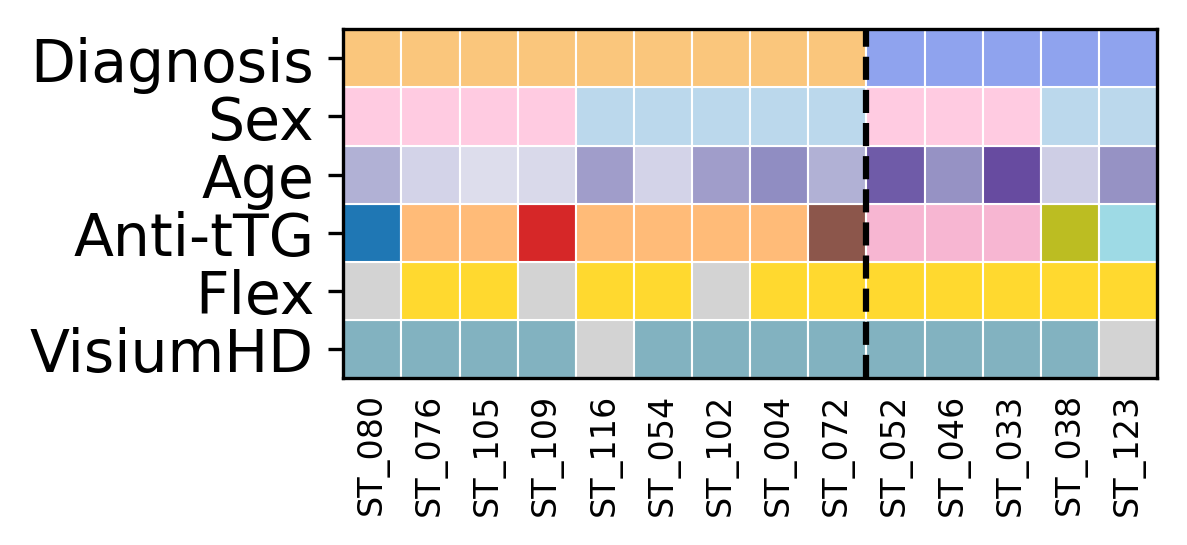

In [19]:
#my_feature_order = ["visiumhd_binary","flex","age_group","sex","diagnosis",added_disease_class]
my_feature_order = ["VisiumHD","Flex","Anti-tTG","Age","Sex","Diagnosis",]
# sort by
# show_df.sort_values(by=["diagnosis", added_disease_class+"_numeric"], ascending=[True, False], inplace=True)
show_df.sort_values(by=["diagnosis", "sex"], ascending=[True, True], inplace=True)

# rename columns in show_df for better visualization
show_df.rename(columns={
    "visiumhd": "VisiumHD",
    "diagnosis": "Diagnosis",
    "flex": "Flex",
    "ttg_value": "Anti-tTG",
    "age": "Age",
    "sex":"Sex"
}, inplace=True)

fig, ax = annotation_strip(show_df, palettes=show_palettes_capital, feature_order = my_feature_order, 
                           cell_size=1.0, show_legend = False, dashed_line_loc=9)
plt.show()

In [20]:
# replace ST_ with "P"
show_df.index = show_df.index.str.replace("ST_", "P")

In [21]:
# make dir figures if not exists
figures_dir = os.getcwd()+"/figures/"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [22]:
show_df

,Diagnosis,Sex,Age,Anti-tTG,VisiumHD,Flex
P080,Celiac,Female,8.5,45.0,True,False
P076,Celiac,Female,5.5,250.0,True,True
P105,Celiac,Female,4.5,250.0,True,True
P109,Celiac,Female,5.0,79.0,True,False
P116,Celiac,Male,10.0,250.0,False,True
P054,Celiac,Male,5.5,250.0,True,True
P102,Celiac,Male,10.0,250.0,True,False
P004,Celiac,Male,11.5,250.0,True,True
P072,Celiac,Male,8.5,154.0,True,True
P052,Control,Female,15.0,0.5,True,True


In [23]:
my_feature_order = my_feature_order[::-1]
my_feature_order

['Diagnosis', 'Sex', 'Age', 'Anti-tTG', 'Flex', 'VisiumHD']

In [24]:
# if /figures/fig3/ doesnt exist - create it
fig1_save_path = os.getcwd()+"/figures/fig1/"
if not os.path.exists(fig1_save_path):
    os.makedirs(fig1_save_path)

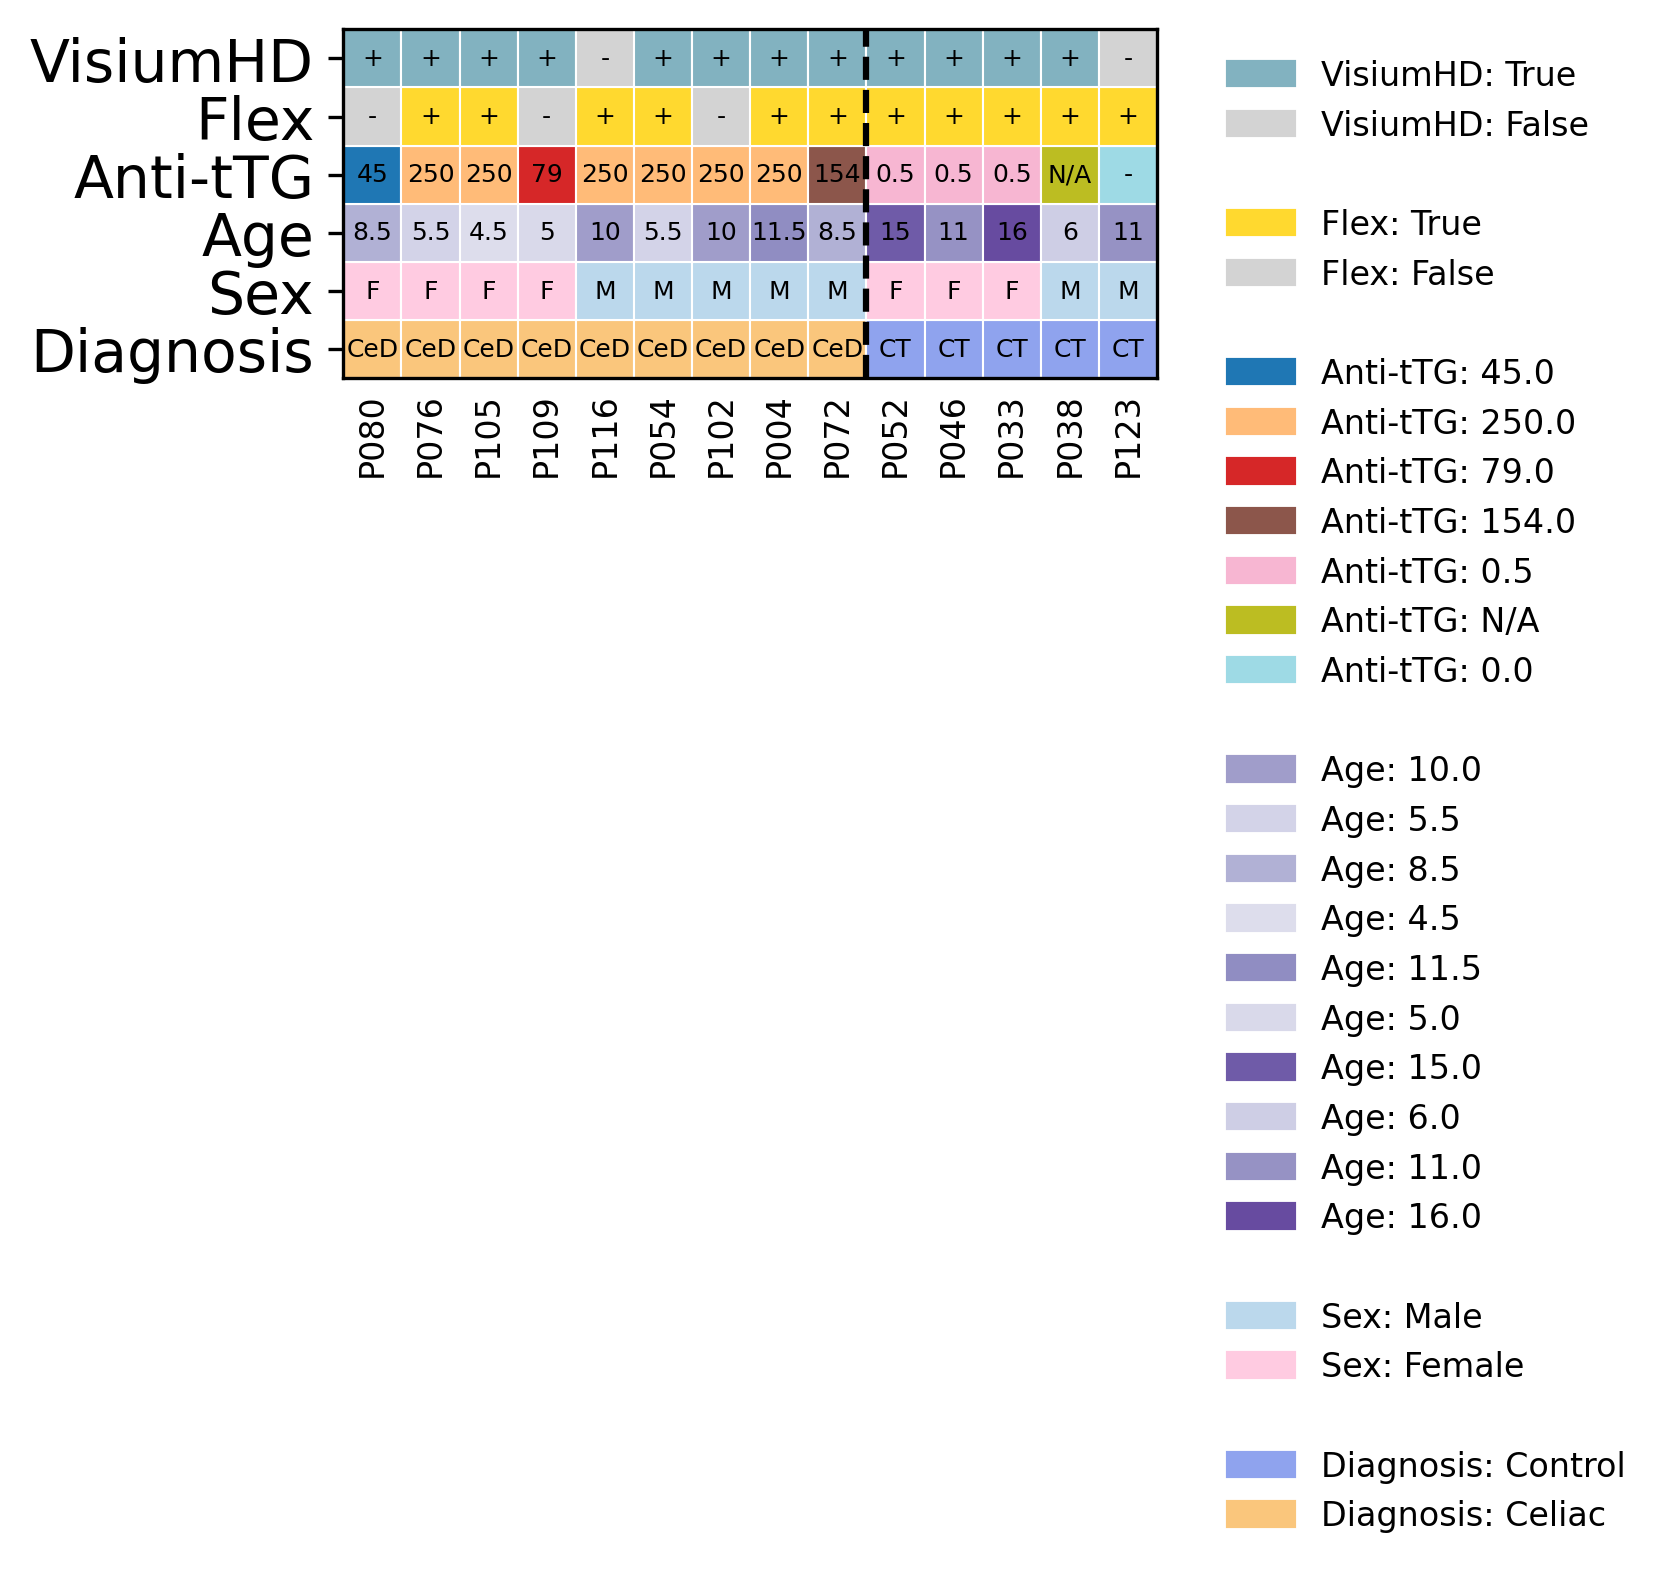

In [25]:
disp_dict = {
    True: "+",
    False: "-",
    "Male": "M",
    "Female":"F",
    "Celiac":"CeD",
    "Control":"CT",
    4.5:"4.5",
    5.0:"5",
    5.5:"5.5",
    6.0:"6",
    8.5:"8.5",
    10.0:"10",
    11.0:"11",
    11.5:"11.5",
    15.0:"15",
    16.0:"16",
    250:"250",
    154:"154",
    0.5:"0.5",
    45:"45",
    79:"79",
    "N/A":"N/A"
    
}
fig, ax = annotation_strip(show_df, palettes=show_palettes_capital, feature_order = my_feature_order, 
                           cell_size=1.0, show_legend = True, dashed_line_loc=9, text_dict=disp_dict)
plt.show()
# export to pdf
fig.savefig(fig1_save_path+"/fig1C_samples_annotations.pdf", bbox_inches='tight')

In [26]:
# export show_df to csv
show_df.to_csv(f"{pb_subfolder_path}sample_annotations.csv")

In [27]:
print(datetime.now())

2026-01-18 16:08:58.760226


In [28]:
print(session_info2.session_info(dependencies=True))

/home/talbarka/miniconda3/envs/celiac_env3/lib/python3.11/site-packages/session_info2/__init__.py:124: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  and (v := getattr(pkg, "__version__", None))


pandas	2.3.1
scanpy	1.11.3
numpy	2.2.6
tqdm	4.67.1
seaborn	0.13.2
matplotlib	3.10.3
geopandas	1.1.1
adjustText	1.3.0
dill	0.4.0
scipy	1.15.3
plotly	6.2.0
squidpy	1.6.5
statsmodels	0.14.5
scikit-learn	1.7.1
gseapy	1.1.9
anndata	0.12.0
----	----
ome-zarr	0.11.1
cloudpickle	3.1.1
sphinxcontrib-devhelp	2.0.0
wcwidth	0.2.13
spatialdata	0.5.0
wrapt	1.17.2
natsort	8.4.0
matplotlib-scalebar	0.9.0
decorator	5.2.1
sphinxcontrib-applehelp	2.0.0
jaraco.context	5.3.0
pyzmq	27.0.0
jaraco.functools	4.0.1
imagecodecs	2025.3.30
requests	2.32.4
joblib	1.5.1
ipython	9.4.0
pytz	2025.2
jupyter_client	8.6.3
shapely	2.1.1
pyct	0.5.0
asttokens	3.0.0
xarray	2025.9.0
validators	0.35.0
tornado	6.5.1
param	2.2.1
MarkupSafe	3.0.2
pyparsing	3.2.3
pyarrow	21.0.0
docrep	0.3.2
debugpy	1.8.15
igraph	0.11.9
imageio	2.37.0
kiwisolver	1.4.8
zipp	3.23.0
toolz	1.0.0
fonttools	4.59.0
psutil	7.0.0
attrs	25.3.0
datashader	0.18.1
PyYAML	6.0.2
sphinxcontrib-htmlhelp	2.1.0
xarray-dataclass	3.0.0
idna	3.10
packaging	25.0
stack-dat